In [1]:
import numpy as np
import pandas as pd

In [2]:
url_inv = "https://open.canada.ca/data/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c/resource/3acf79c0-a5f5-4d9a-a30d-fb5ceba4b60a/download/service_inventory.csv"
url_std = "https://open.canada.ca/data/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c/resource/272143a7-533e-42a1-b72d-622116474a21/download/service_standards.csv"

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df_inv = pd.read_csv(url_inv)

In [ ]:
df_inv.head()

In [4]:
df_inv.describe()

,fiscal_yr,service_id,service_name_en,service_name_fr,department_name_en,department_name_fr,external_internal,service_type,special_designations,service_description_en,...,other_applications,e_registration,e_authentication,e_application,e_decision,e_issuance,e_feedback,client_feedback,special_remarks_en,special_remarks_fr
count,1865,1865,1865,1865,1865,1865,1865,1865,1865,1865,...,1865,1139,1224,1306,1330,1218,1488,1343,1240,1075
unique,3,1232,1337,1355,67,68,12,74,9,1416,...,265,2,2,2,2,2,2,99,746,648
top,2018-2019,1548,Public Enquiries,Demandes des médias,"Immigration, Refugees and Citizenship Canada","Immigration, Réfugiés et Citoyenneté Canada",extern,reg,non,"The Program makes use of regulatory measures, ...",...,0,Y,N,N,N,N,Y,"tel,onl",This service is not available through other se...,Ce service n'est pas disponible via d'autres m...
freq,1180,5,9,4,226,226,1461,558,1135,9,...,892,575,691,725,783,723,749,143,37,42


In [5]:
df_inv.columns

Index(['fiscal_yr', 'service_id', 'service_name_en', 'service_name_fr',
       'department_name_en', 'department_name_fr', 'external_internal',
       'service_type', 'special_designations', 'service_description_en',
       'service_description_fr', 'service_url_en', 'service_url_fr',
       'program_name_en', 'program_name_fr', 'last_GBA',
       'client_target_groups', 'info_service', 'service_fee',
       'cra_business_number', 'use_of_sin', 'service_channels',
       'online_applications', 'web_visits_info_service', 'calls_received',
       'in_person_applications', 'postal_mail_applications',
       'other_applications', 'e_registration', 'e_authentication',
       'e_application', 'e_decision', 'e_issuance', 'e_feedback',
       'client_feedback', 'special_remarks_en', 'special_remarks_fr'],
      dtype='object')

# Data Cleanup

## Numeric columns

In [6]:
#Convert object columns to numeric data type.
numeric_columns = ['web_visits_info_service', 'calls_received', 'online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications']
for col in numeric_columns:
    df_inv[col] = pd.to_numeric(df_inv[col], errors = 'coerce')

In [7]:
#Sum total applications
applications=['online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications']
df_inv["total_applications"]=df_inv[applications].sum(axis=1)

## Department name and Fiscal year

AS observed noted by Dia, data over all three years is only available for 11 departments. We restrict ourselves to these. Furthermore, Danyi's graph shows a significant decrease in the number of applications (online and otherwise) in the fiscale year 2018-2019. We assume that these are do to a lack of data. Therefore, we also restrict ourselves to the fiscal years 2016-2017 and 2017-2018.

For more information, read comments [here](https://open.canada.ca/data/en/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c).

In [8]:
df_inv.fiscal_yr.unique()

array(['2016-2017', '2017-2018', '2018-2019'], dtype=object)

In [9]:
departments = df_inv[df_inv.fiscal_yr == '2016-2017'].department_name_en.unique()
df = df_inv[df_inv.department_name_en.isin(departments) & (df_inv.fiscal_yr != '2018-2019')]

In [10]:
df.head()

,fiscal_yr,service_id,service_name_en,service_name_fr,department_name_en,department_name_fr,external_internal,service_type,special_designations,service_description_en,...,e_registration,e_authentication,e_application,e_decision,e_issuance,e_feedback,client_feedback,special_remarks_en,special_remarks_fr,total_applications
0,2016-2017,135,Farm Debt Mediation Service,Service de médiation en matière d'endettement ...,Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,"prior,crit",Provides financial counselling and mediation s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The use of""NA"" in the SIN column is an indica...",NaN,282.0
1,2016-2017,136,AgriMarketing Program Assurance Systems,"Programme Agri-marketing, volet Systèmes d'ass...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides funding for the development of nation...,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,16.0
2,2016-2017,137,AgriMarketing Program Market Development,"Programme Agri-marketing, volet Développement ...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides funding to industry associations and ...,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,141.0
3,2016-2017,138,AgriInnovation Program Industry-led Research a...,"Programme Agri-innovation, Activités de recher...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides support for pre-commercialization Res...,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,29.0
4,2016-2017,139,AgriInnovation Program Enabling Commercializat...,"Programme Agri-innovation, Facilitation de la ...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides repayable contributions to approved i...,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,36.0


## External_internal

Much of this is copied from Dia's notebook

In [11]:
df_inv.external_internal.value_counts()

extern                      1461
enterprise                   220
extern,enterprise            136
extern,intern                 18
extern,enterprise,intern       9
intern                         6
enterprise,extern              6
enterprise,intern              5
intern,enterprise,extern       1
enterprise,extern,intern       1
extern,intern,enterprise       1
intern,extern                  1
Name: external_internal, dtype: int64

In [12]:
def translate_to_EI(val):
    if val == 'extern':
        return 'EX'
    elif val in ['enterprise', 'intern', 'enterprise,intern']:
        return 'IN'
    else:
        return 'EI'

In [14]:
#df_inv.external_internal
df_inv['external_internal'] = df_inv['external_internal'].map(translate_to_EI)
df_inv.external_internal.value_counts()

EX    1461
IN     231
EI     173
Name: external_internal, dtype: int64

## Selecting relevant columns

We begin by redefining df to only contain the columns that will be of interest to us.


In [13]:
rel_cols = ['fiscal_yr', 'service_name_en', 'department_name_en', 'external_internal',
            'service_type', 'client_target_groups', 'service_fee','use_of_sin', 
            'online_applications', 'web_visits_info_service', 'calls_received',
            'in_person_applications', 'postal_mail_applications', 'other_applications', 
            'e_registration', 'e_authentication', 'e_application', 'e_decision', 'e_issuance', 'e_feedback']
df = df[rel_cols]
df.head()

,fiscal_yr,service_name_en,department_name_en,external_internal,service_type,client_target_groups,service_fee,use_of_sin,online_applications,web_visits_info_service,calls_received,in_person_applications,postal_mail_applications,other_applications,e_registration,e_authentication,e_application,e_decision,e_issuance,e_feedback
0,2016-2017,Farm Debt Mediation Service,Agriculture and Agri-Food Canada,extern,res,econom,N,ND,282.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-2017,AgriMarketing Program Assurance Systems,Agriculture and Agri-Food Canada,extern,res,econom,N,ND,16.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Y,Y,N,N
2,2016-2017,AgriMarketing Program Market Development,Agriculture and Agri-Food Canada,extern,res,econom,N,ND,141.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Y,Y,N,N
3,2016-2017,AgriInnovation Program Industry-led Research a...,Agriculture and Agri-Food Canada,extern,res,NGO,N,ND,29.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Y,Y,N,N
4,2016-2017,AgriInnovation Program Enabling Commercializat...,Agriculture and Agri-Food Canada,extern,res,econom,N,ND,36.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Y,Y,N,N


# Data Plotting and Preliminary Exploration

## Web visits and applications

In [61]:
#Selecting important columns
df_web = df[['fiscal_yr', 'department_name_en', 'web_visits_info_service', 'online_applications', 'total_applications']]

#Remove rows where web_visits_info_service or total_applications are null
df_web = df_web[(df_web.web_visits_info_service != 0) & (df_web.total_applications != 0)]

#Head
df_web.head()

,fiscal_yr,department_name_en,web_visits_info_service,online_applications,total_applications
185,2016-2017,Employment and Social Development Canada,65387512.0,144469.0,144469.0
188,2016-2017,Employment and Social Development Canada,43943.0,0.0,970.0
194,2016-2017,Employment and Social Development Canada,11727.0,0.0,14911.0
347,2017-2018,Agriculture and Agri-Food Canada,20863.0,149.0,780.0
348,2017-2018,Agriculture and Agri-Food Canada,1276.0,23.0,24.0


In [74]:
#Remaining departments
departments_web = df_web.department_name_en.unique()

### Total applications

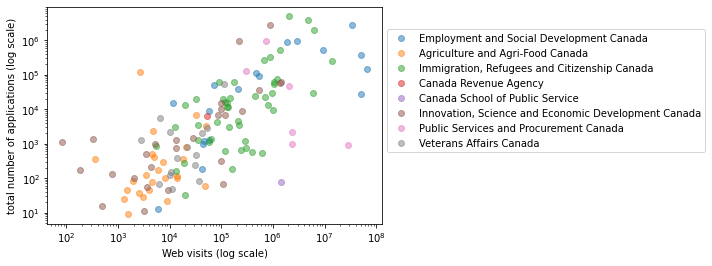

In [75]:
import matplotlib.pyplot as plt

#plot
for dept in departments_web:
    temp_df = df_web[df_web.department_name_en == dept]
    plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.total_applications, label=dept, alpha = 0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Web visits (log scale)')
plt.ylabel('total number of applications (log scale)')
plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

#### Separating by fiscal year

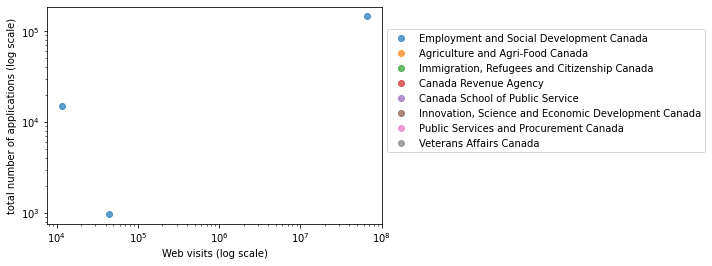

In [76]:
#Fiscal Year 2016-2017

df_web_16_17 = df_web[df_web.fiscal_yr == '2016-2017']

for dept in departments_web:
    temp_df = df_web_16_17[df_web_16_17.department_name_en == dept]
    plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.total_applications, label=dept, alpha = 0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Web visits (log scale)')
plt.ylabel('total number of applications (log scale)')
plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

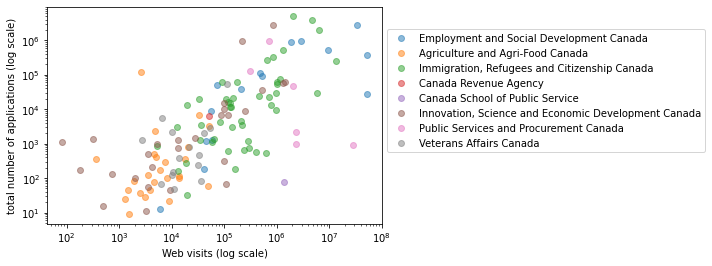

In [77]:
#Fiscal Year 2017-2018

df_web_17_18 = df_web[df_web.fiscal_yr == '2017-2018']

for dept in departments_web:
    temp_df = df_web_17_18[df_web_17_18.department_name_en == dept]
    plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.total_applications, label=dept, alpha = 0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Web visits (log scale)')
plt.ylabel('total number of applications (log scale)')
plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

### Online applications

In [78]:
#We remove rows with no online applications
df_online = df_web[df_web.online_applications != 0]

In [81]:
#Remaining departments
departments_online = df_online.department_name_en.unique()
df_online.department_name_en.value_counts()

Innovation, Science and Economic Development Canada    26
Immigration, Refugees and Citizenship Canada           20
Agriculture and Agri-Food Canada                       15
Veterans Affairs Canada                                13
Employment and Social Development Canada               13
Public Services and Procurement Canada                  5
Canada Revenue Agency                                   1
Name: department_name_en, dtype: int64

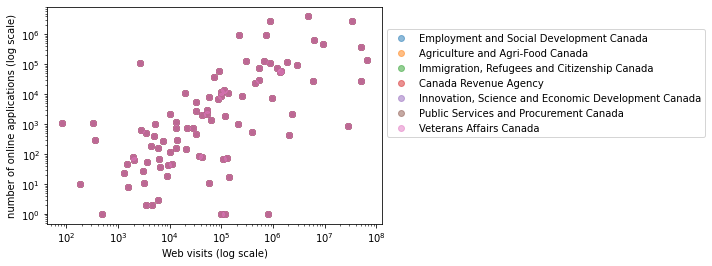

In [84]:
#plot
for dept in departments_online:
    temp_df = df_online[df_online.department_name_en == dept]
    plt.scatter(x = df_online.web_visits_info_service, y = df_online.online_applications, label=dept, alpha = 0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Web visits (log scale)')
plt.ylabel('number of online applications (log scale)')
plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

### Online applications

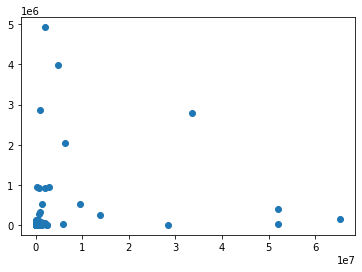

In [27]:
plt.scatter(df_web.web_visits_info_service, df_web.total_applications)
plt.show()

In [28]:
df_web_gr = df_web.groupby('department_name_en').agg('sum')
df_web_gr

,web_visits_info_service,online_applications,total_applications
department_name_en,,,
Agriculture and Agri-Food Canada,270991.0,114118.0,139784.0
Canada Revenue Agency,51839.0,2281.0,6541.0
Canada School of Public Service,1413254.0,0.0,77.0
Employment and Social Development Canada,218795168.0,4166883.0,6041093.0
"Immigration, Refugees and Citizenship Canada",47023287.0,5135380.0,12927802.0
"Innovation, Science and Economic Development Canada",5366143.0,3981923.0,4015876.0
Public Services and Procurement Canada,36044251.0,1062968.0,1110191.0
Veterans Affairs Canada,405803.0,23239.0,68568.0


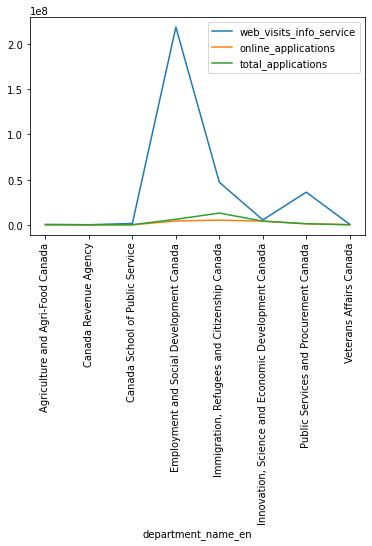

In [29]:
df_web_gr.plot()
plt.xticks(rotation = 90)
plt.show()

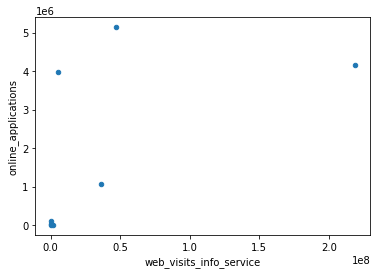

In [31]:
df_web_gr.plot(kind='scatter',x='web_visits_info_service',y='online_applications')
plt.show()

## Seperating by Year

Looking at same data above, seperated by year. (Just curious)

In [ ]:
df_inv_online_data_w_yr = df_inv_relevantDeps[[
'fiscal_yr','department_name_en', 'web_visits_info_service', 'online_applications']]
df_inv_online_data_w_yr.head()

In [ ]:
df_inv_onine_data_1617=df_inv_online_data_w_yr[df_inv_online_data_w_yr.fiscal_yr=='2016-2017']
df_inv_onine_data_by_year=df_inv_online_data_w_yr.groupby('fiscal_yr')
for name, group in df_inv_onine_data_by_year:
    print(name)
    group.plot(kind='scatter',x='web_visits_info_service',y='online_applications')
    plt.show()
#graph = sb.FacetGrid(data = df_inv_online_data_w_yr, col = "fiscal_yr")
#graph.map(plt.scatter, 'web_visits_info_service', 'online_applications')

In [ ]:
#group by department
df_inv_onine_data_1617=df_inv_onine_data_1617.groupby('department_name_en').agg(sum)
df_inv_onine_data_1617.shape

In [ ]:
df_inv_onine_data_1617.plot()
plt.xticks(rotation = 90)
#plt.legend()
plt.show()

# Merge Experiment

Merged all departments together to 1) show a way to do that with quatitative data and 2) play arund with plotting multiple bar charts

Inclduing it here just so people can be see. May delete later. 

In [ ]:
df_inv_apps_data = df_inv_relevantDeps[['fiscal_yr','department_name_en', 'online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications', 'total_applications']]
df_inv_apps_data.head()

In [ ]:
#del df_inv_apps_data['department_name_en']

In [ ]:
#column_list=['online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications']
#df_inv_apps_data["total_applications"]=df_inv_apps_data[column_list].sum(axis=1)

In [ ]:
df_inv_apps_data_merge=df_inv_apps_data.groupby('fiscal_yr').agg(sum)
df_inv_apps_data_merge.head()

In [ ]:
fig1, ax1=plt.subplots()

ax1.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.online_applications, label='online applications')
ax1.set_title("Online Applications")
fig2,ax2=plt.subplots()
ax2.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.in_person_applications)
ax2.set_title('In-person Applications')

fig3, ax3=plt.subplots()
ax3.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.postal_mail_applications)
ax3.set_title("Postal mail applications")

fig4, ax4=plt.subplots()
ax4.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.other_applications)
ax4.set_title("Other applications")

fig5, ax5=plt.subplots()
ax5.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.total_applications)
ax5.set_title("Total applications")

plt.show()

# Decision Tree Regression

In [52]:
# Before converting data, we have to replace some nan columns
columns_to_code = ['service_fee', 'e_registration', 'e_authentication','e_application', 'e_decision', 'e_issuance', 'e_feedback']
df_inv[columns_to_code].describe()

,service_fee,e_registration,e_authentication,e_application,e_decision,e_issuance,e_feedback
count,1865,1139,1224,1306,1330,1218,1488
unique,2,2,2,2,2,2,2
top,0,1,0,0,0,0,1
freq,1423,575,691,725,783,723,749


In [56]:
# Convert categorical data we need to analyze to numerical
for col in columns_to_code:
    df_inv[col + '_code'] = df_inv[col].map({'N' : 0, 'Y' : 1, np.nan : -1})
df_inv.head()

,fiscal_yr,service_id,service_name_en,service_name_fr,department_name_en,department_name_fr,external_internal,service_type,special_designations,service_description_en,...,special_remarks_en,special_remarks_fr,total_applications,service_fee_code,e_registration_code,e_authentication_code,e_application_code,e_decision_code,e_issuance_code,e_feedback_code
0,2016-2017,135,Farm Debt Mediation Service,Service de médiation en matière d'endettement ...,Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,"prior,crit",Provides financial counselling and mediation s...,...,"The use of""NA"" in the SIN column is an indica...",NaN,282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-2017,136,AgriMarketing Program Assurance Systems,"Programme Agri-marketing, volet Systèmes d'ass...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides funding for the development of nation...,...,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-2017,137,AgriMarketing Program Market Development,"Programme Agri-marketing, volet Développement ...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides funding to industry associations and ...,...,NaN,NaN,141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-2017,138,AgriInnovation Program Industry-led Research a...,"Programme Agri-innovation, Activités de recher...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides support for pre-commercialization Res...,...,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-2017,139,AgriInnovation Program Enabling Commercializat...,"Programme Agri-innovation, Facilitation de la ...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,extern,res,prior,Provides repayable contributions to approved i...,...,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Data to fit
X = df_inv_16_17[columns_to_code]
y = df_inv_16_17.total_applications

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=15)
tree_model.fit(X, y)

In [ ]:
print("Data")
print(X)
print(y)
print("Predictions")
print(tree_model.predict(X.head()))